## Tutorial on enzyme design with ProteinMPNN and data analysis of generated sequences

### 1. Problem statement: 

- We are given an enzyme with a bound cofactor in the active site. We want to redesign (and diversify) its sequence while retaining active site residues from native. How can we achieve it? The most straightforward option would be **ProteinMPNN** (doi: 10.1126/science.add21) - a message passing graph neural network that has been shown remarkable inverse folding modelling accuracy. In this tutorial we will try to understand how to use ProteinMPNN and analyze generated data relying on several scripts.

### 2. Requirements for the tutorial: 

- The following tutorial requires basic knowledge of python, understanding of ProteinMPNN and ESMfold (or AlphaFold2). The tutorial doesn't serve a purpose to explain how all the mentioned software works. 

- In order to run ProteinMPNN, you should have installed and configured a conda environment (see https://github.com/dauparas/ProteinMPNN/tree/main). To predict protein structures of designed sequences, ESMfold should be installed (https://github.com/facebookresearch/esm). 

- If installation is not possible, use the webservers of ProteinMPNN (https://huggingface.co/spaces/simonduerr/ProteinMPNN) and ESMfold (https://esmatlas.com/resources?action=fold). ESMfold has a size limitation of 400 aa residues! 

### 3. Protein of interest for input
- Input to ProteinMPNN is a structural file (.pdb) of a protein of interest. ProteinMPNN processes pdbs and ignores water or ions, so no pre-processing has to be carried out. Though I would recommend deleting all unneccessary HETATMs. 

- In the tutorial we will work with HotAldO (https://www.uniprot.org/uniprotkb/A0LST6) - an FAD-dependent monooxygenase catalyzing oxidation of 1,2-diols. It is a monomeric enzyme of 46 kDa molecular weight; there is no crystal/cryoEM structure available for HotAldO. However, a crystal structure of a close homologue AldO (https://www.uniprot.org/uniprotkb/Q9ZBU1) is available with bound FAD and a substrate xylose (https://www.rcsb.org/structure/2VFS). This important information will help us in a bit.

- Let's visualize AldO! We will visualize it in py3dmol in this notebook. If you don't have py3dmol installed, run the following cell in your terminal: 

In [1]:
pip install py3Dmol

Note: you may need to restart the kernel to use updated packages.


- Provide location for downloaded .pdb file and let's take a look at it:

In [2]:
import py3Dmol

AldO = '/Users/ncyx/Desktop/pMPNN_analysis/examples/pdbs/input/2vfs.pdb' # location of the pdb file

view = py3Dmol.view(width=400, height=300)
AldO_pdb = open(AldO).read()
view.addModel(AldO_pdb, 'pdb')
view.setBackgroundColor('white')

protein = {'chain':'A'}
selection = {'resn':'FAD', 'chain':'A', 'byres':'true', 'expand': 6}
view.setStyle({'chain': 'A'}, {'cartoon': {'color': 'white'}})  # Cartoon representation for chain A (protein)
view.setStyle({'resn': 'FAD'},{'stick': {'colorscheme': 'greenCarbon'}})
view.setStyle({'resn': 'XYL'},{'stick': {'colorscheme': 'pinkCarbon'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

- We see AldO as a white cartoon, FAD as green and XYL as pink sticks. We can very roughly (without any literature research) define an active site as residues surrounding a substrate XYL and cofactor FAD. But this is not our protein of interest! What we will do next, is we will download an AlphaFol2 predicted structure of HotAldO and simply insert FAD into the .pdb file of HotAldO. 

- **Warning**: this is an acceptable approach if two homologues share (very) high sequence and structure similarity. It it is not the case, one should properly dock a cofactor and a substrate into an active site of a protein of interest (POI). AldO is nearly identical to HotAldO in the active site, so we don't do docking here. 

- HotAldO AlphaFold2 (AF2) prediction can be found here: https://alphafold.ebi.ac.uk/entry/A0LST6

- Download AF2 prediction and transpose coordinates of FAD and XYL into .pdb file of HotAldO. This can be done either in PyMOL, Chimera or e.g. in commanline using cat and grep commands. 

- Let's now take a look at our corresponding HotAldO with bound FAD and XYL:

In [3]:
HotAldO = '/Users/ncyx/Desktop/pMPNN_analysis/examples/pdbs/input/HotAldO_FAD_XYL.pdb'
view = py3Dmol.view(width=400, height=300)
HotAldO_pdb = open(HotAldO).read()
view.addModel(HotAldO_pdb, 'pdb')
view.setBackgroundColor('white')

protein = {'chain':'A'}
view.setStyle({'chain': 'A'}, {'cartoon': {'color': 'cornflowerblue'}})  # Cartoon representation for chain A (protein)
view.setStyle({'resn': 'FAD'},{'stick': {'colorscheme': 'greenCarbon'}})
view.setStyle({'resn': 'XYL'},{'stick': {'colorscheme': 'pinkCarbon'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

- HotAldO is depicted now as a blue cartoon. Perhaps there are some steric clashes with FAD, so docking might be a good idea in this case as well. But since we only care about residues 6 $\AA$ around our cofactor in this "frankenstein" HotAldO, it is acceptable. 

- Now how does the selection of residues 6 $\AA$ around FAD looks like?

In [4]:
selection = {'resn':'FAD', 'chain':'A', 'byres':'false', 'expand': 6}
view.setStyle(selection,{'stick':{'colorscheme':'lightgreyCarbon'}})
view.setStyle({'resn': 'FAD'},{'stick': {'colorscheme': 'greenCarbon'}})
view.setStyle({'resn': 'XYL'},{'stick': {'colorscheme': 'pinkCarbon'}})

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### 4. Fixing residues

- We now have familiriaze ourselves with our protein of interest. Let's finally fix residues which are going to be retained in pMPNN design. We will use a script developed for this purpose (available as CLI as well). 

- for myself: think here about location of scripts in the github repo

In [5]:
from fix_res_select import *

```fix_res_select``` contains a class **res_selection** which defines a function **fix_residues**. We will use it to find residues positions in 6 $\AA$ around FAD and XYL:

In [31]:
test = res_selection(HotAldO, ['FAD', 'XYL']) #definition of the class; first arg = loc of a pdb, second = list of HETATMs as str
fixed_res = test.fix_residues(6)

print('number of residues we will fix:', len(fixed_res))
print('residue numbers we will fix:')
for i in fixed_res:
	print(i, end=' ')

print('\nlength of HotAldO is 417 => we fix', round(len(fixed_res)/417*100,0), 'percent of residues')

--- heteroatoms found: ['FAD', 'XYL']  ---
--- selected fixed residues for pMPNN design around FAD ---
--- selected fixed residues for pMPNN design around XYL ---
number of residues we will fix: 62
residue numbers we will fix:
8 9 15 40 41 42 43 44 45 46 47 48 49 51 52 61 79 80 100 101 102 103 106 107 109 110 111 112 113 114 115 116 117 118 158 159 160 161 163 164 165 166 280 281 285 287 289 291 319 321 371 372 373 374 208 248 249 273 274 317 342 344 
length of HotAldO is 417 => we fix 15.0 percent of residues


- This string of residue numbers separated by a space is an input for pMPNN design script to fix residues. Now we have a .pdb file of HotAldO and positions we want to fix. The design script which was used to generate sequences with pMPNN can be found in examples folder. 

- I won't go to any details on all parameters pMPNN uses during inference, the github repo of pMPNN has a great documentation of all modii operandi: https://github.com/dauparas/ProteinMPNN/tree/main

- I designed 150 sequences (default = 8) with sampling T = 0.1 (less diversity) using soluble model weights. You can experiment with different settings!  

### 5. Understanding fasta output of ProteinMPNN

- .fa file which is the output of pMPNN contains wildtype sequence and specificed number of designed variants with some metadata. Let's take a look at the structure of a fasta output:

In [32]:
HotAldO_des_fa = '/Users/ncyx/Desktop/pMPNN_analysis/examples/fasta/sol_HotAldO.fa'

with open(HotAldO_des_fa, 'r') as fasta:
	lines = fasta.readlines()
lines[:4] # first 4 lines of the fasta file

[">HotAldO_AF2, score=1.4256, global_score=1.4169, fixed_chains=[], designed_chains=['A'], model_name=v_48_020, git_hash=8907e6671bfbfc92303b5f79c4b5e6ce47cdef57, seed=159\n",
 'MSAPRLRNWAGNIAFRPRRYVQPRDLDELVEIIRVSDQVRVLGTGHSFNPIADTTGTLISLDHLPREVRVMPGRTAVSAGTRYGDLAFPLHEAGWALANVGSLPHISIAGACATATHGSGDRNGCLATAVAGMTGVDGTCRVFHLTAESPEFPGAVVHLGALGAVTEIELVTEPTFTVRQWVYEDAPLDNVFADLDDVTSAAYSVSIFTTWDPPTARQIWLKERVAAGRPDPPARRWGGRLAERDHNPVPGMPPENCTPQLGRIGPWHERLPHFRLDVTPSAGDELQSEYFVPRAAAVEAYRALRHIGSRIAPVLQISEIRTVAADELWLSPAYHRPSVAFHFTWIADEEAVRPVVSEVERALAPLQPRPHWGKLFTMDPAVVRAAYPRFDDFVALAERYDPEGKFQNDFLRRFFAG\n',
 '>T=0.1, sample=1, score=0.7976, global_score=0.8718, seq_recovery=0.5042\n',
 'AAPPVLRNWAGNIEFTPARVIEPRSLEELREAIRNSEQVRVLGTGHSFNPIADTEGTLISLRHLPRFIEISEGRVRVSAWLTYGELARPIEEAGLQLETMPSDPHISVAGAIATATHGSGDRLGCLADLVTGLRGIDGRGEEFEFTREDPRFPLLVVNLGTLGAVTEIELATVPAADYRVWVYTDAPLADVVAHFDEVMSAAYSVRLFTLWSPPVVTQARLVVRVEPGHAEPPARVWGGTLATEELHPVPGADPSLCTPQLGQVGPAYERLPLYRADATPFDGDFLQSAYYVAREDAAAAVERLLAIADQIAPVTLVCE

- We will use all the metadata in our downstream analysis. What important now is that each uneven line is a sequence while headers are evenly numbered including 0 index. We can easily extract sequences:

In [33]:
all_seqs = [lines[i].strip('\n') for i in range(len(lines)) if i %2 != 0]
orig_seq = all_seqs[0]
orig_seq # original sequence

'MSAPRLRNWAGNIAFRPRRYVQPRDLDELVEIIRVSDQVRVLGTGHSFNPIADTTGTLISLDHLPREVRVMPGRTAVSAGTRYGDLAFPLHEAGWALANVGSLPHISIAGACATATHGSGDRNGCLATAVAGMTGVDGTCRVFHLTAESPEFPGAVVHLGALGAVTEIELVTEPTFTVRQWVYEDAPLDNVFADLDDVTSAAYSVSIFTTWDPPTARQIWLKERVAAGRPDPPARRWGGRLAERDHNPVPGMPPENCTPQLGRIGPWHERLPHFRLDVTPSAGDELQSEYFVPRAAAVEAYRALRHIGSRIAPVLQISEIRTVAADELWLSPAYHRPSVAFHFTWIADEEAVRPVVSEVERALAPLQPRPHWGKLFTMDPAVVRAAYPRFDDFVALAERYDPEGKFQNDFLRRFFAG'

- By having a .fa file with sequences, we can fold all of them using **ESMfold** (doi: 10.1126/science.ade2574). The script used to fold all 150 variants and native HotAldO can be found in examples folder. 

### 6. Analyzing pMPNN-designed sequences and interpreting the results


Now the fun stuff begins. We will use several hand-coded scripts to extract interesting data from .fa and structures of pMPNN-designed variants and then will visualize all the results in some plots. 

- In the first part we will extract plddt values of predictions, rmsd to native, will compute some biophysical parameters and then take a look at the dataset we generated.

- We will need to provide a .fa file with designed sequences, folder with .pdb files of predicted sequences

In [34]:
from mpnn_analysis import *

```mpnn_analysis``` contains a class **mpnn_analysis** which processess results from .fa and .pdb (predictions) files and aggregates them in one data set. For more details, read documentation of all the functions

In [35]:
HotAldO_des_fa = '/Users/ncyx/Desktop/pMPNN_analysis/examples/fasta/sol_HotAldO.fa'
des_predictions_ESMfold = '/Users/ncyx/Desktop/pMPNN_analysis/examples/pdbs/ESMfold_pred'

In [36]:
HotAldO_analysis = mpnn_analysis(HotAldO_des_fa, None, des_predictions_ESMfold, str_predict='ESMfold')
data_HotAldO_des = HotAldO_analysis.aggregate_data() # this method will conduct analyses on sequences and structures and return them in a pandas dataframe

input_plddt: 92.62
--- reading pdbs ---
--- calculating fraction of exposed redesigned residues ---


/Users/ncyx/Desktop/pMPNN_analysis/scripts/mpnn_analysis.py:397: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frac_hydrophilic_subset_ref.append(round(hydrophil_subset_ref[0]/(hydrophil_subset_ref[0]+hydrophil_subset_ref[1]),3))
/Users/ncyx/Desktop/pMPNN_analysis/scripts/mpnn_analysis.py:398: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frac_hydrophilic_subset_redes.append(round(hydrophil_subset_redes[0]/(hydrophil_subset_redes[0]+hydrophil_subset_redes[1]),3))
/Users/ncyx/Desktop/pMPNN_analysis/scripts/mpnn_analysis.py:397: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future ver

--- finished after 7.2 seconds ---
--- calculating total charge ---
--- finished after 7.0 ---
--- calculating core size ---
--- finished after 6.6 ---
--- total running time of the script: 22.4 seconds ---


- We defined a class and then executed a function which aggregates data in one data set. What data is there? We extracted sequence recovery & identity, plddt and some interesting biophysical metrics. Among those are: fraction of exposed designed residues, fraction of hydrophilic exposed residues, total charge of proteins and their core sizes. 

- The latter metrics are approximations and have to be inspected with caution. Core size is the number of solvent-excluded residues; charges are approximated by taking only negatively/positively charged residue types and ignoring microenvironment. 

- Let's take a look at the dataset we generated:

In [40]:
print('rows, columns:', data_HotAldO_des.shape)
data_HotAldO_des.head()

rows, columns: (150, 10)


,sample_name,seq_recovery,seq_identity,plddt,frac_exposed_ref,frac_exposed_redes,hydrophilic_exposed_ref,hydrophilic_exposed_redes,charges_total,core_size
0,sample=1,0.5042,0.5707,86.10,0.447,0.441,0.662,0.747,-19,43
1,sample=2,0.5125,0.5779,87.49,0.472,0.466,0.663,0.683,-24,44
2,sample=3,0.5125,0.5779,86.32,0.472,0.506,0.651,0.697,-19,37
3,sample=4,0.4875,0.5564,87.36,0.449,0.476,0.675,0.716,-10,31
4,sample=5,0.5097,0.5755,86.41,0.446,0.441,0.646,0.679,-16,43


- I have prepared a class to plot interesting properties we extracted and some additional metrics explaining how ProteinMPNN works (with pre-loaded soluble weights in this case)

In [41]:
from plot_mpnn_analysis import *

In [42]:
figs_out = '/Users/ncyx/Desktop/pMPNN_analysis/examples/figs_out'
plotting_class = plot_mpnn_analysis(data_HotAldO_des, HotAldO_des_fa, None, des_predictions_ESMfold, figs_out = figs_out, str_predict='ESMfold')

- Please, open documentation of the class to understand what functions do what; for now I will only show the most useful ones. 

- First, let's plot sequence recovery and sequence identity: 

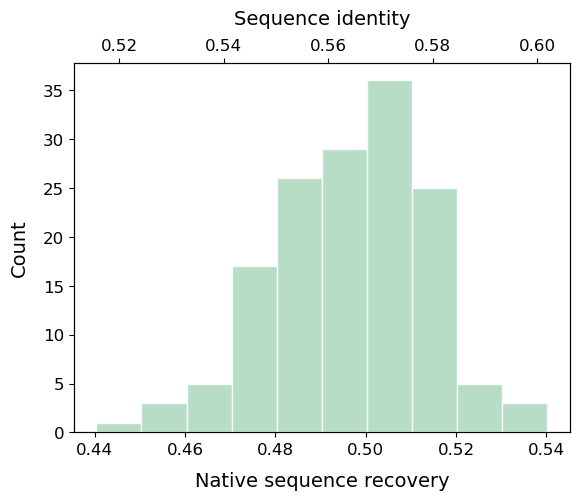

In [43]:
plotting_class.plot_seq_recovery(save='no')

- Reported native sequence recovery of pMPNN is around 51%, so it performs in our case as expected. Though we have fixed quite some residues from the native protein, therefore sequence identity to the native is a more interesting metric. We see that on avg designed variants are nearly 60% identical to wt. 

- Let's now analyze what common residue exchanges we can find. We will plot a 20x20 heatmap with original residue type on x-axis and designed residue type on y-axis: 

,A,C,F,G,I,L,M,P,V,W,D,E,H,K,N,Q,R,S,T,Y
A,0.385493,0.040212,0.031027,0.014038,0.050733,0.046512,0.375674,0.061722,0.081299,0.239691,0.070398,0.122348,0.090243,NaN,0.020000,0.029191,0.085206,0.156810,0.052228,0.051107
C,0.001992,0.269841,NaN,NaN,NaN,NaN,NaN,NaN,0.000528,NaN,0.024382,NaN,NaN,NaN,NaN,NaN,NaN,0.029570,NaN,NaN
F,0.002898,NaN,0.403595,NaN,NaN,0.081072,NaN,NaN,0.003431,0.201031,0.000343,0.056241,NaN,NaN,NaN,0.000834,NaN,0.010305,0.003482,0.049972
G,0.001087,0.287831,NaN,0.754728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096689,NaN,NaN,NaN,0.000639,0.021505,NaN,NaN
I,0.001992,0.012698,0.026102,0.009748,0.466993,0.058463,NaN,NaN,0.215389,0.000859,NaN,0.014471,0.001172,NaN,NaN,0.020017,0.000213,NaN,0.024373,NaN
L,0.058136,NaN,0.038414,0.083057,0.061125,0.598837,0.238645,0.000323,0.018213,0.054983,NaN,0.048676,0.137709,NaN,0.242857,0.156797,0.043029,0.000448,0.123607,0.005679
M,0.006882,NaN,0.006895,NaN,0.000611,0.006460,0.154734,NaN,0.040121,NaN,NaN,0.028614,NaN,NaN,NaN,0.001668,NaN,0.003136,0.049791,0.081772
P,0.063389,0.196825,NaN,0.058491,NaN,NaN,NaN,0.745032,0.002112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019171,NaN,0.000696,NaN
V,0.084760,0.152381,0.046294,0.004289,0.336186,0.065568,NaN,NaN,0.425366,0.009450,0.017170,0.083210,0.009376,0.49,NaN,0.170142,0.041964,0.047939,0.138231,0.211244
W,NaN,NaN,0.018715,0.050302,NaN,0.000646,NaN,NaN,NaN,0.288660,NaN,0.000329,0.008790,NaN,NaN,0.011676,0.000426,0.000896,NaN,0.001136


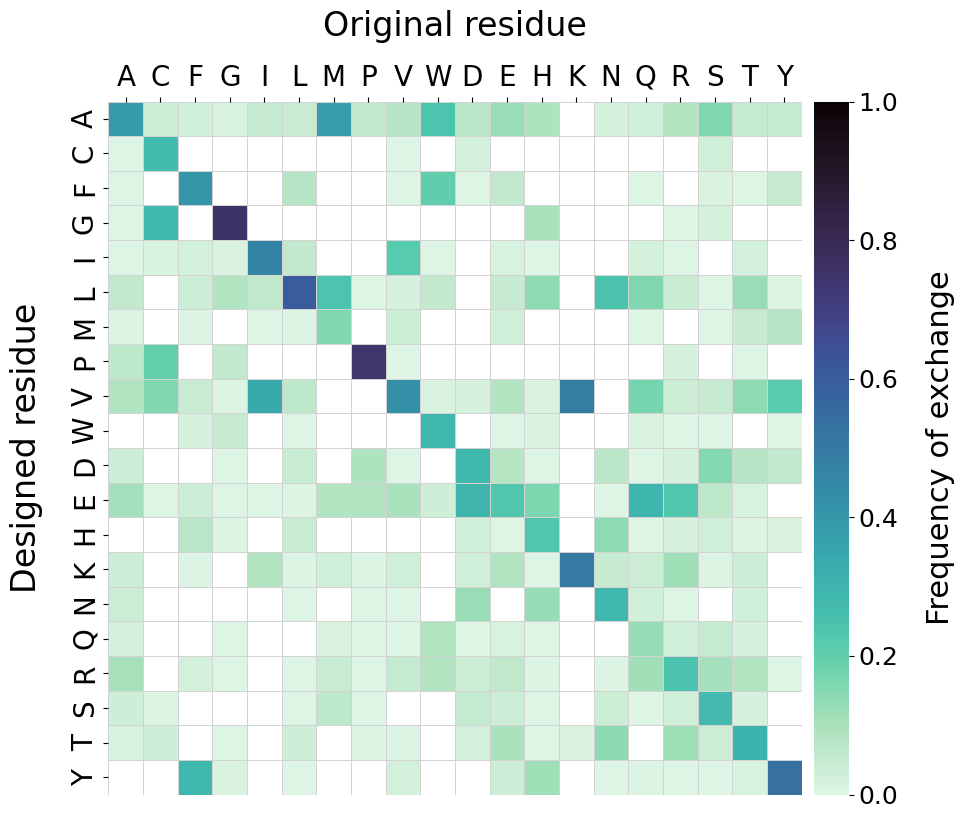

In [44]:
plotting_class.heatmap_exchanged_residues(sort_hydrophobic=True, non_wt_only=False, save='no', )

- This function iteratively counts what residues appear at each of the native sequence positions from the .fa file. Diagonal in this case represents "wt-wt exchange" meaning pMPNN retains these residues from native HotAldO. It turns out that GLY, PRO and LEU are the most commonly retained residues! This does make sense since GLY and PRO are important for structural integrity of protein folds: they introduce turns and kinks. Keeping them at wildtype positions should guarantee that the protein adopts the desired fold.

- Interestingly, (I digged into it) at one position pMPNN mutated K -> V in many designed sequences, so it stands out if one normalizes to the total exchanges of lysines. We can say that pMPNN actually doesn't like to touch lysines at all! 

- Maybe now let's consider only wt-non wt exchanges, so that diagonal is zero:

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
A,NaN,0.055072,0.098843,0.159588,0.052023,0.057234,0.117289,0.095183,NaN,0.115942,0.444444,0.028000,0.242079,0.033397,0.113026,0.216853,0.075226,0.141479,0.336957,0.109489
C,0.003242,NaN,0.034233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.040892,NaN,0.000919,NaN,NaN
D,0.061892,NaN,NaN,0.100386,NaN,0.001590,0.003808,NaN,NaN,0.111111,NaN,0.097333,0.358682,0.001908,0.020910,0.206320,0.113842,0.000459,NaN,0.121655
E,0.171824,0.002899,0.418997,NaN,0.063584,0.009539,0.211729,0.003440,NaN,0.015298,0.098361,0.001333,0.328264,0.332061,0.310540,0.088600,0.020060,0.167203,0.045894,NaN
F,0.004716,NaN,0.000482,0.073359,NaN,NaN,NaN,NaN,NaN,0.202093,NaN,NaN,NaN,0.000954,NaN,0.014250,0.005015,0.005972,0.282609,0.107056
G,0.001768,0.394203,NaN,NaN,NaN,NaN,0.125666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000848,0.029740,NaN,NaN,NaN,NaN
H,NaN,NaN,0.040501,0.001287,0.123865,0.031797,NaN,NaN,NaN,0.116747,NaN,0.196000,NaN,0.002863,0.024866,0.041512,0.008024,NaN,NaN,0.017032
I,0.003242,0.017391,NaN,0.018876,0.043765,0.039746,0.001523,NaN,NaN,0.145733,NaN,NaN,NaN,0.022901,0.000283,NaN,0.035105,0.374828,0.001208,NaN
K,0.059829,NaN,0.039537,0.117117,0.009083,NaN,0.003046,0.154817,NaN,0.011272,0.032787,0.070667,0.027883,0.048664,0.150608,0.008055,0.055667,0.050988,NaN,NaN
L,0.094607,NaN,NaN,0.063492,0.064410,0.338633,0.178979,0.114679,NaN,NaN,0.282332,0.340000,0.001267,0.179389,0.057078,0.000620,0.178034,0.031695,0.077295,0.012165


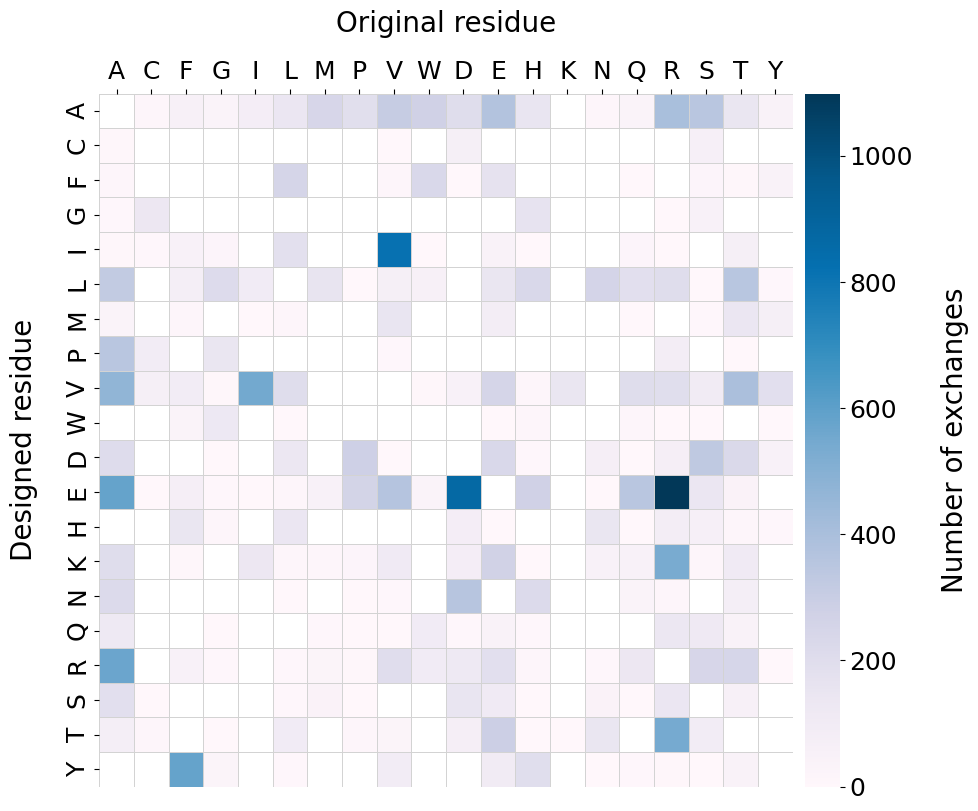

In [45]:
plotting_class.heatmap_exchanged_residues(sort_hydrophobic=True, non_wt_only=True, save='no')

- We count here number of exchanges, so it's sensitive to the occurence of the residue type in the native sequence. We see that pMPNN decided to very frequently mutate ARG to GLU. This changes the charge of the protein by 2 digits per each such mutation!

- What if we now try to plot charge of the designed solvent exposed residues?

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

input vs. design: Custom statistical test, P_val:4.526e-49


,charges,annot
0,-2,input
1,1,input
2,-1,input
3,-2,input
4,-1,input
...,...,...
295,-14,design
296,-7,design
297,-13,design
298,-6,design


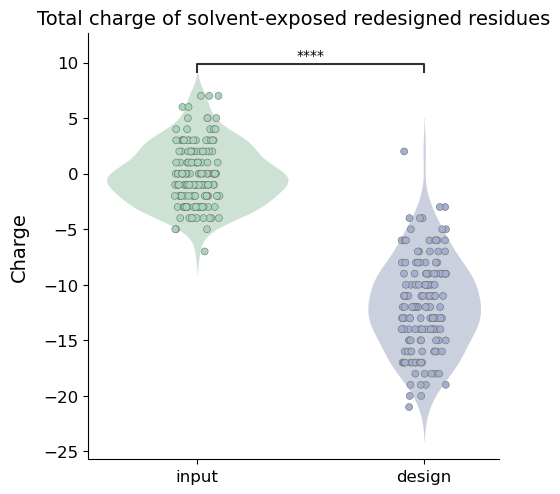

In [46]:
plotting_class.plot_charges(selection = 'exposed', save='no', )

- ```plot_charges``` first computes positions where pMPNN mutated original sequence for all 150 designs. Then it subsets only those designed residues that are solvent exposed (based on SASA values) and then computes their charge. That means we have only one protein for "input" label and 150 different for design. We are comparing iteratively residue indices from native HotAldO to each of the corresponding redesigned indices in 150 designs.

- It turns out that pMPNN with soluble pre-loaded weights rendered surface of designs negatively charged.

- Now let's take a look at the total charge distribution of our designs:

--- finished after: 0.03283572196960449 ---


[-19,
 -24,
 -19,
 -10,
 -16,
 -24,
 -20,
 -19,
 -21,
 -14,
 -23,
 -9,
 -23,
 -24,
 -18,
 -14,
 -19,
 -18,
 -16,
 -18,
 -15,
 -18,
 -13,
 -12,
 -17,
 -22,
 -22,
 -16,
 -13,
 -18,
 -14,
 -12,
 -21,
 -17,
 -18,
 -20,
 -23,
 -23,
 -20,
 -20,
 -13,
 -17,
 -17,
 -24,
 -14,
 -29,
 -17,
 -18,
 -18,
 -17,
 -14,
 -19,
 -16,
 -23,
 -16,
 -29,
 -23,
 -21,
 -20,
 -19,
 -19,
 -16,
 -19,
 -19,
 -25,
 -23,
 -19,
 -21,
 -20,
 -17,
 -14,
 -19,
 -13,
 -21,
 -15,
 -21,
 -15,
 -16,
 -18,
 -19,
 -16,
 -19,
 -21,
 -20,
 -27,
 -23,
 -13,
 -15,
 -10,
 -18,
 -17,
 -20,
 -17,
 -27,
 -18,
 -13,
 -23,
 -19,
 -20,
 -22,
 -14,
 -17,
 -18,
 -10,
 -14,
 -21,
 -17,
 -19,
 -24,
 -21,
 -21,
 -10,
 -13,
 -17,
 -21,
 -21,
 -16,
 -18,
 -14,
 -16,
 -22,
 -11,
 -15,
 -17,
 -15,
 -16,
 -24,
 -15,
 -18,
 -14,
 -9,
 -23,
 -25,
 -14,
 -25,
 -18,
 -15,
 -25,
 -17,
 -22,
 -22,
 -23,
 -18,
 -11,
 -19,
 -23,
 -17,
 -21,
 -15,
 -13]

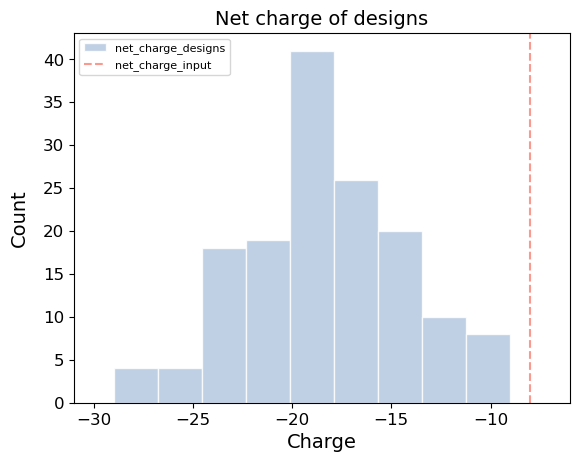

In [47]:
plotting_class.plot_charges(selection = 'total', save='no', )

- Indeed, as expected, designs possess higher negative charge than the wildtype.

- Another metric we can investigate is hydrophilicity of solvent-exposed designed residues. Perhaps we would expect if sol pMPNN negatively charges surfaces that our solvent-exposed regions might have become more hydrophilic ..?

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

input vs. design: Custom statistical test, P_val:1.717e-30


,hydrophilic_frac_exposed,annot
0,0.662,input
1,0.663,input
2,0.651,input
3,0.675,input
4,0.646,input
...,...,...
295,0.742,design
296,0.771,design
297,0.773,design
298,0.731,design


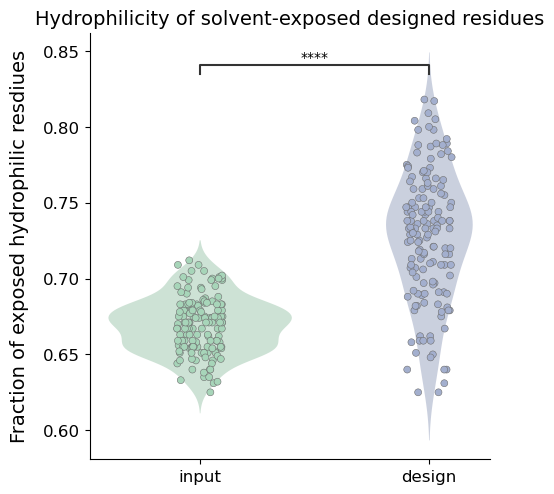

In [48]:
plotting_class.violin_hydrophilic_exposed(save='no')

- Among the redesigned solvent-exposed residues, hydrophilic residues dominate.

### 7. Conclusions


This tutorial introduced the pipeline of pMPNN and suggested metrics to analyze when redesigning enzyme for the improved solubility. Our analyses showed that sol pMPNN (i) rendered protein surfaces more hydrophilic, (ii) negatively charged, and (iii) that we can find distinct preferred introduced mutations in the heatmaps. 

Credits: Seva Viliuga